In [4]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import csv
import gzip
import anndata as ad
from pathlib import Path
import glob

sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.8.0
scanpy      1.9.1
-----
MulticoreTSNE               NA
PIL                         9.1.0
appnope                     0.1.2
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.0
cloudpickle                 2.1.0
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2022.9.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fsspec                      2022.8.2
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.10.1
ipykernel                   6.9.1
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
jinja2                      3.0.3
joblib   

In [5]:
def calculator(sample):

    # STEP 1 -> set corresponding folders which the results of each specimen are written to
    output_folder = "/Users/lidiayung/project/specimens"
    resource_folder = "/Users/lidiayung/project/resource/GSE174554_RAW/"
 
    matrix_path = glob.glob(f"{resource_folder}/GSM*_{sample}_matrix.mtx.gz")[0]
    features_path = glob.glob(f"{resource_folder}/GSM*_{sample}_features.tsv.gz")[0]
    barcodes_path = glob.glob(f"{resource_folder}/GSM*_{sample}_barcodes.tsv.gz")[0]


    output_path = os.path.join(output_folder, sample)
    results_file = f"{output_path}/gbm.h5ad"
    
    if len(features_path) == 0:
        print(f"No document found for sample {sample}")
        return None

    # End of Step 1

    # STEP 2 -> creat output documents
    # path to unfiltered loom file (this will be created in the optional steps below)
    f_loom_path_unfilt = "unfiltered.loom" # test dataset, n=500 cells
    f_loom_path_scenic = "filtered_scenic.loom"
    f_anndata_path = "anndata.h5ad"
    f_pyscenic_output = "output.loom"
    f_final_loom = 'scenic_integrated-output.loom'

    # End of Step 2

    # Step 3-> read data into anndata
    mat = scipy.io.mmread(matrix_path)
    feature_ids = [row[0] for row in csv.reader(gzip.open(features_path, mode="rt"), delimiter="\t")]
    gene_names = [row[0] for row in csv.reader(gzip.open(features_path, mode="rt"), delimiter="\t")]
    feature_types = [row[0] for row in csv.reader(gzip.open(features_path, mode="rt"), delimiter="\t")]
    barcodes = [row[0] for row in csv.reader(gzip.open(barcodes_path, mode="rt"), delimiter="\t")]
    matrix = pd.DataFrame.sparse.from_spmatrix(mat)
    matrix.columns = barcodes
    matrix=matrix.transpose() 
    matrix.columns = gene_names

    # convert the index and columns to DataFrame objects
    obs_df = matrix.index.to_frame(index=False)
    var_df = matrix.columns.to_frame(index=False)

    adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)


    row_attrs = {  "Gene": np.array(var_df[0]) ,}
    col_attrs = { "CellID":  np.array(matrix.index) , 
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
    }
    lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )   

    # End of Step 3

    #Step 4-> Filtering cells that have >2.5% mitochondrial read counts and <200 expressed genes

    adata = sc.read_loom( f_loom_path_unfilt )
    nCountsPerGene = np.sum(adata.X, axis=0)
    nCellsPerGene = np.sum(adata.X>0, axis=0)
        
    nCells=adata.X.shape[0]

    mito_genes = adata.var_names.str.startswith('MT-')
    # for each cell compute fraction of counts in mito genes vs. all genes
    adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    sc.pp.filter_cells(adata, min_genes=200 )
    adata = adata[adata.obs['percent_mito'] <=0.025, :]
    #End of Step 4

    #Step 5 -> Read filtered data
    adata.write( f_anndata_path )
    # create basic row and column attributes for the loom file:
    row_attrs = {    "Gene": np.array(adata.var_names) ,}
    col_attrs = {
     "CellID": np.array(adata.obs_names) ,
     "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
     "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
     }
    lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)
    
    #End of Step 5
    
    #Step 6 -> integrate metadata
    file = "/Users/lidiayung/project/resource/GSE174554_RAW/GSE174554_Tumor_normal_metadata.txt"
    metadata= pd.read_csv(file,sep=' ')
    metadata.head()
    #End of Step 6

    #Step 7 -> Calculate percentage and return the value from both pre and post data
    new_df = metadata[metadata["Sample#"] == sample].copy()
    new_df['Barcode'] = new_df['Barcode'].astype(str) + '-1'
    intersection_barcodes = set(new_df['Barcode']).intersection(adata.obs.index)
    tumor = new_df[new_df['Barcode'].isin(intersection_barcodes) & (new_df['Tumor_Normal_annotation'] == 'Tumor')]
    percentage = "{:.2%}".format(len(tumor)/len(adata.obs.nUMI))
    #print("Percentage: {:.2%}".format(len(tumor)/len(adata.obs.nUMI)))
    post_filtering = f"{len(tumor)}/{len(adata.obs.nUMI) - len(tumor)}"
    
    sample_str = f"{post_filtering}"
    print(sample_str)
    #End of Step 7
    
    # Total-count normalize (library-size correct) to 10,000 reads/cell
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

    # log transform the data.
    sc.pp.log1p(adata)

    # identify highly variable genes.
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pl.highly_variable_genes(adata)
    adata.raw = adata

    # keep only highly variable genes:
    adata = adata[:, adata.var['highly_variable']]
    
    # regress out total counts per cell and the percentage of mitochondrial genes expressed
    sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)
    # scale each gene to unit variance, clip values exceeding SD 10.
    sc.pp.scale(adata, max_value=10)
    # update the anndata file:
    adata.write( f_anndata_path )
    adata.write(results_file)

#not matching samples
samples = ['SF10099','SF11587','SF11720','SF11857','SF12704','SF4209','SF4810','SF6186','SF7307','SF9715','SF9962']
#'SF10022',
for sample in samples:
    obtainpercentage, post_filtering = calculator(sample)
    results.append((sample, obtainpercentage, post_filtering))

## Create a pandas DataFrame with the results
df_unmatching = pd.DataFrame(results, columns=['Sample', 'Post-filtering','Percentage'])
print(df_unmatching)

In [6]:
calculator('SF8963')

ValueError: invalid literal for int() with base 10: b'1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_24975/2285189700.py:46: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0/2709
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes


/Users/lidiayung/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


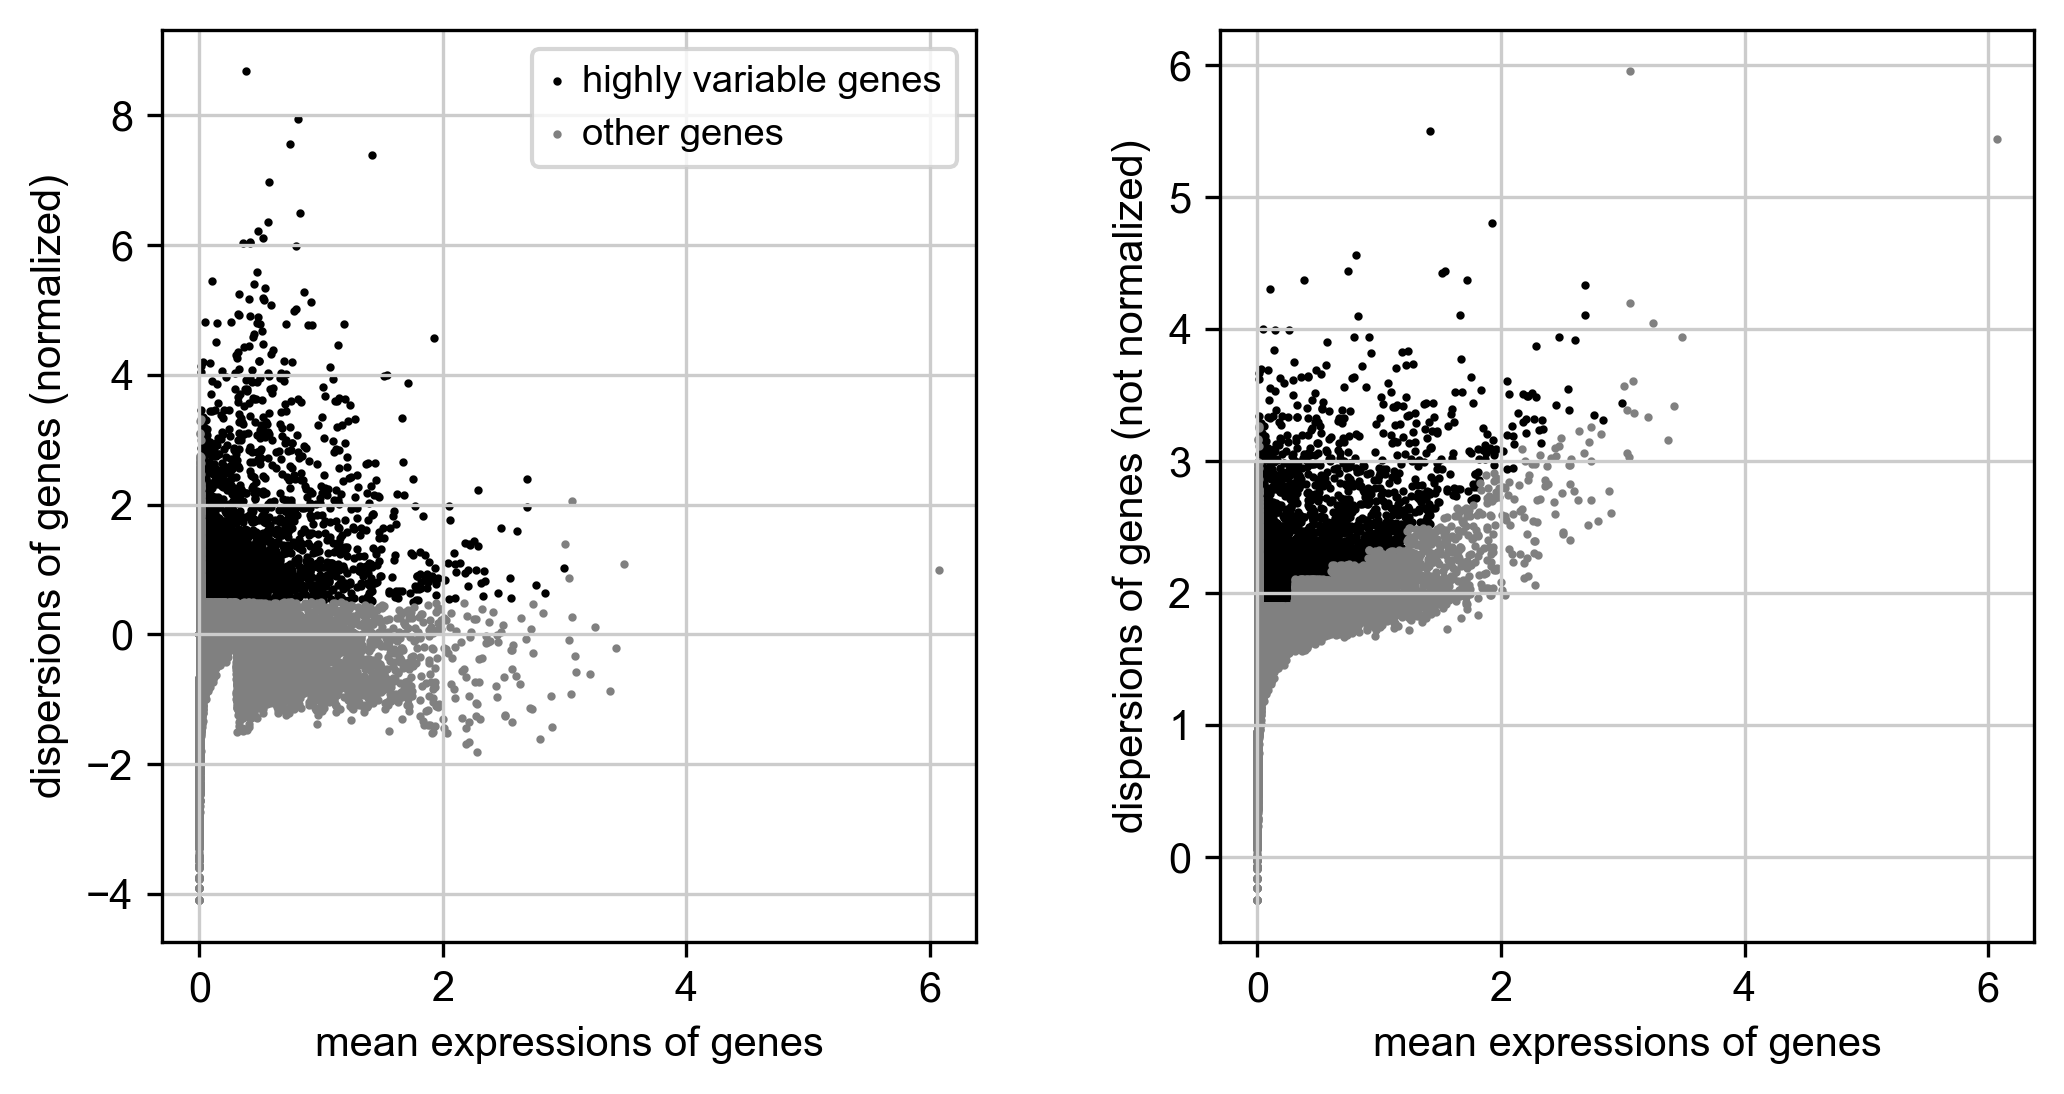

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:25)


In [35]:
calculator('SF1343')

In [ ]:
#Step 6 -> integrate metadata
    file = "/Users/lidiayung/project/resource/GSE174554_RAW/GSE174554_Tumor_normal_metadata.txt"
    metadata= pd.read_csv(file,sep=' ')
    metadata.head()
    #End of Step 6

    #Step 7 -> Calculate percentage and return the value from both pre and post data
    new_df = metadata[metadata["Sample#"] == sample].copy()
    new_df['Barcode'] = new_df['Barcode'].astype(str) + '-1'
    intersection_barcodes = set(new_df['Barcode']).intersection(adata.obs.index)
    tumor = new_df[new_df['Barcode'].isin(intersection_barcodes) & (new_df['Tumor_Normal_annotation'] == 'Tumor')]
    percentage = "{:.2%}".format(len(tumor)/len(adata.obs.nUMI))
    #print("Percentage: {:.2%}".format(len(tumor)/len(adata.obs.nUMI)))
    post_filtering = f"{len(tumor)}/{len(adata.obs.nUMI) - len(tumor)}"
    
    sample_str = f"{post_filtering}"
    #End of Step 7

In [6]:
samples = ['SF3076','SF11873','SF11344']
results_all=[]
for sample in samples:
    obtainpercentage, post_filtering = calculator(sample)
    results_all.append((sample, obtainpercentage, post_filtering))

# Create a pandas DataFrame with the results
df_results = pd.DataFrame(results_all, columns=['Sample', 'Post-filtering','Percentage'])
print(df_results)


/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_24975/3940613181.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_24975/3940613181.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)

    Sample Post-filtering Percentage
0   SF3076       2332/882     72.56%
1  SF11873         0/3130      0.00%
2  SF11344       589/5194     10.19%


/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_24975/1501262883.py:46: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes


/Users/lidiayung/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


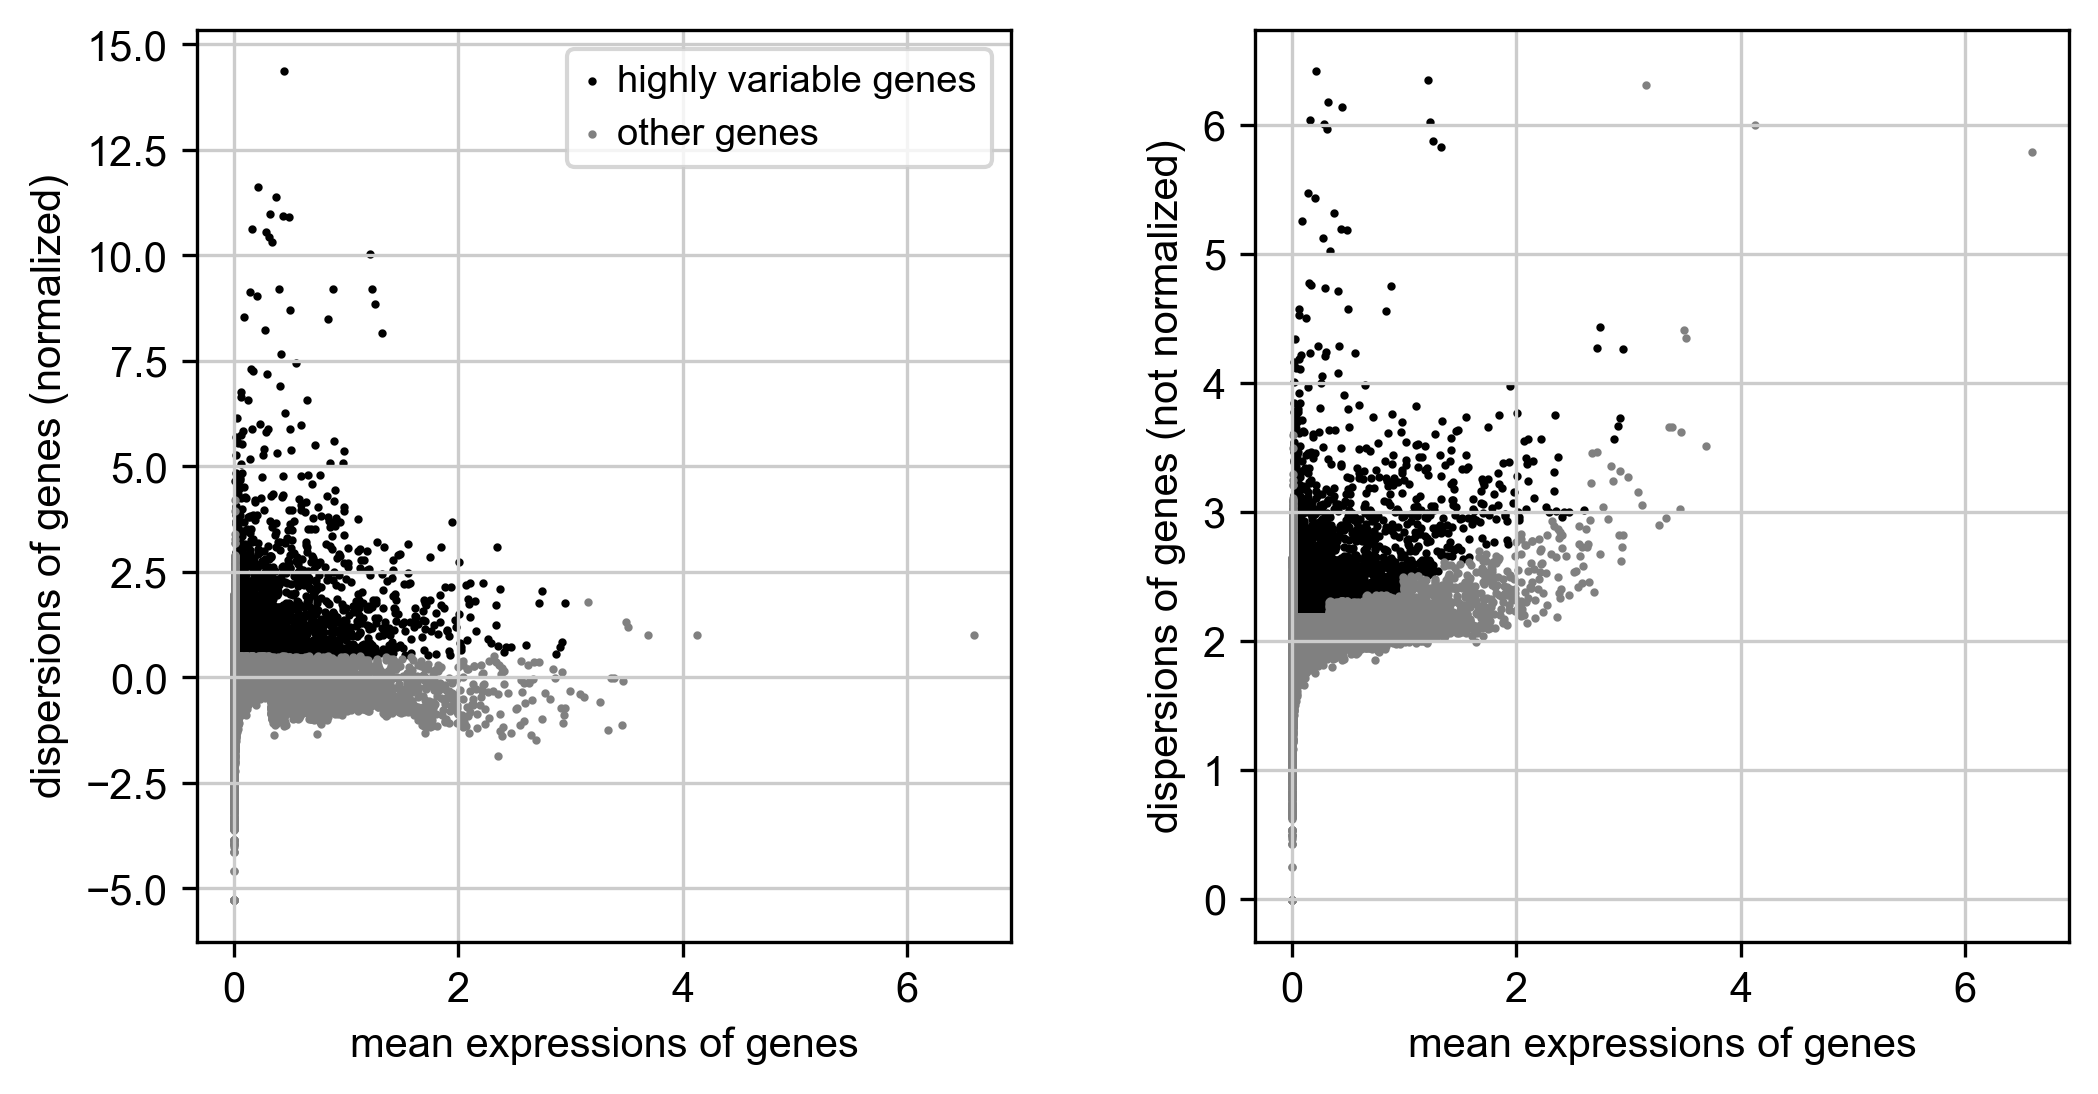

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:28)


In [31]:
calculator('SF3076')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_24975/3703550910.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


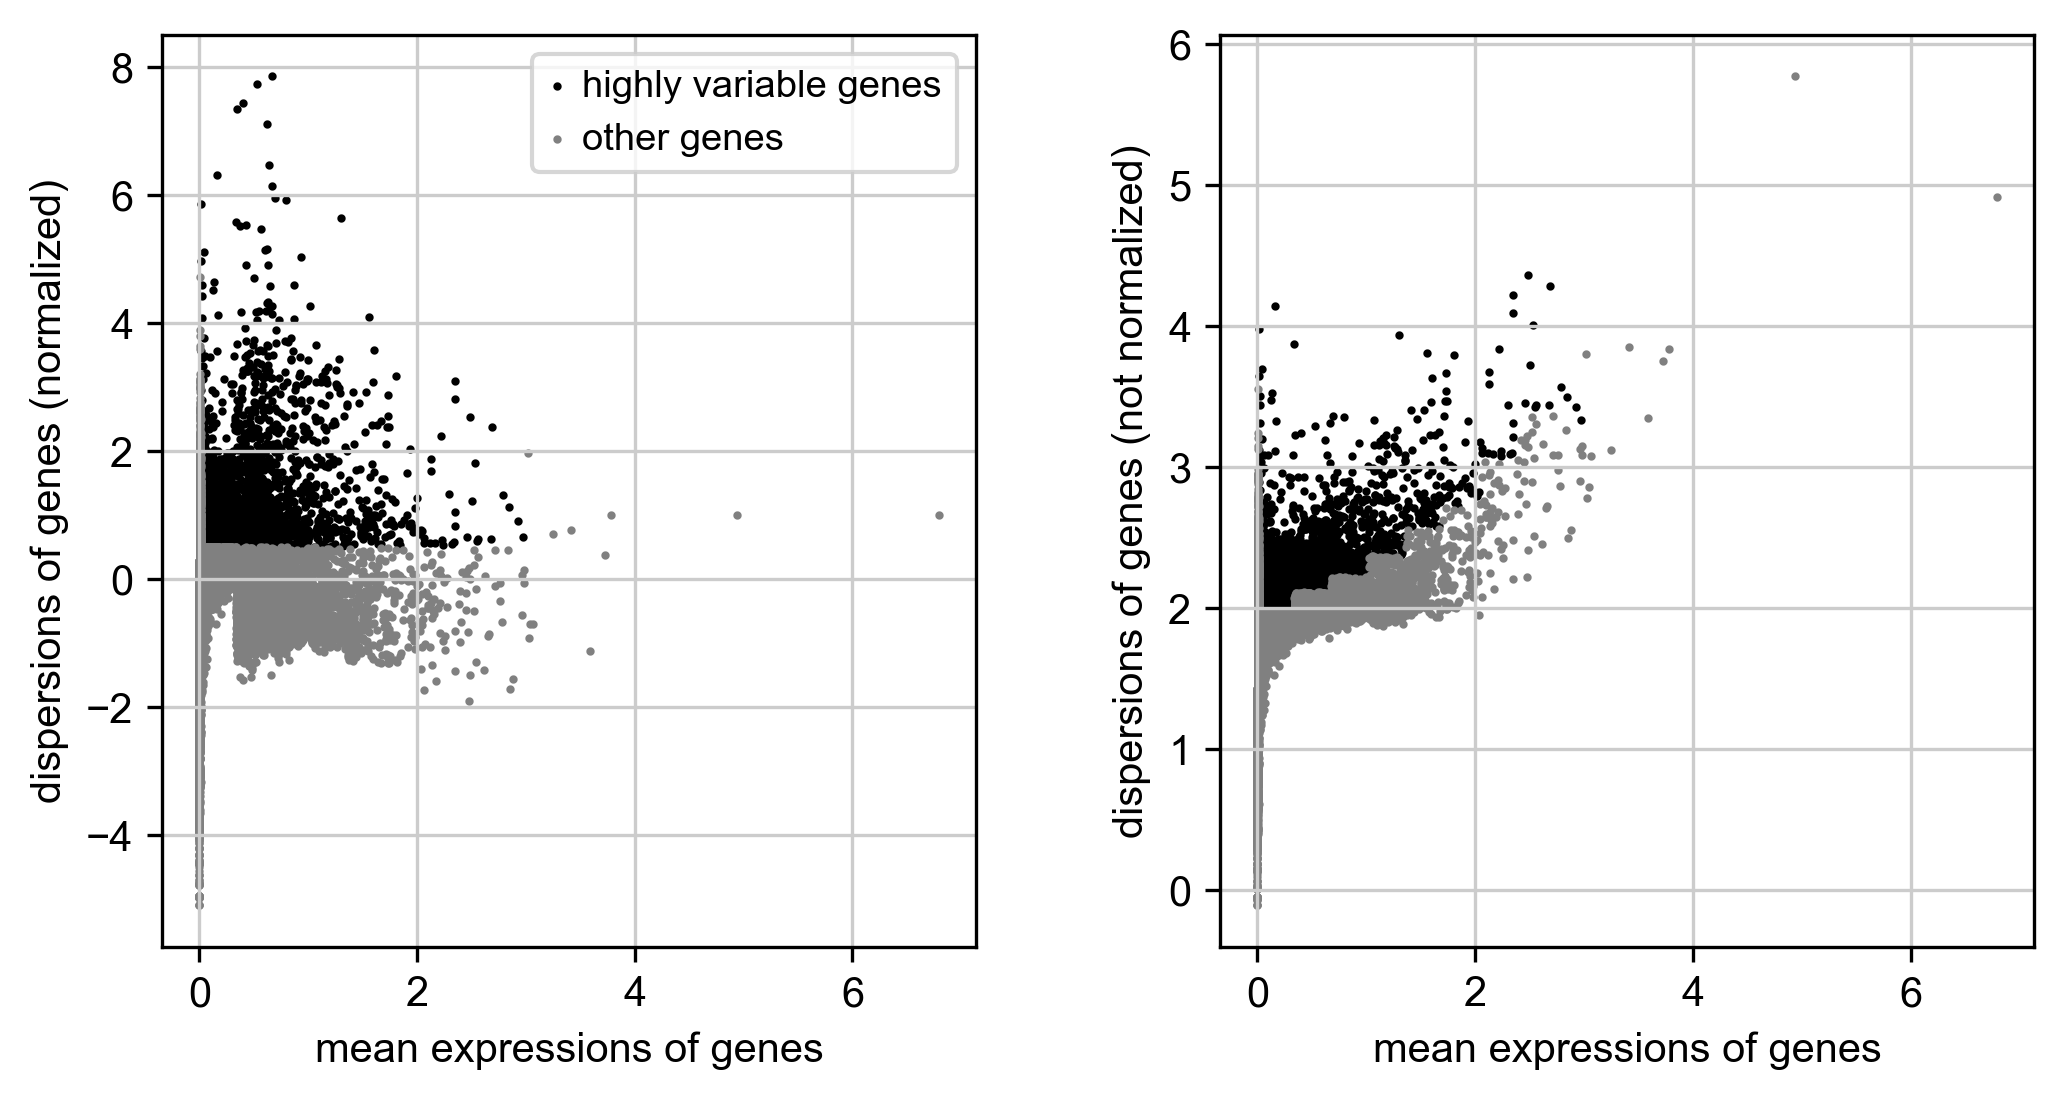

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:50)


('1602/2654', '37.64%')

In [19]:
calculator('SF12460')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_24975/3703550910.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


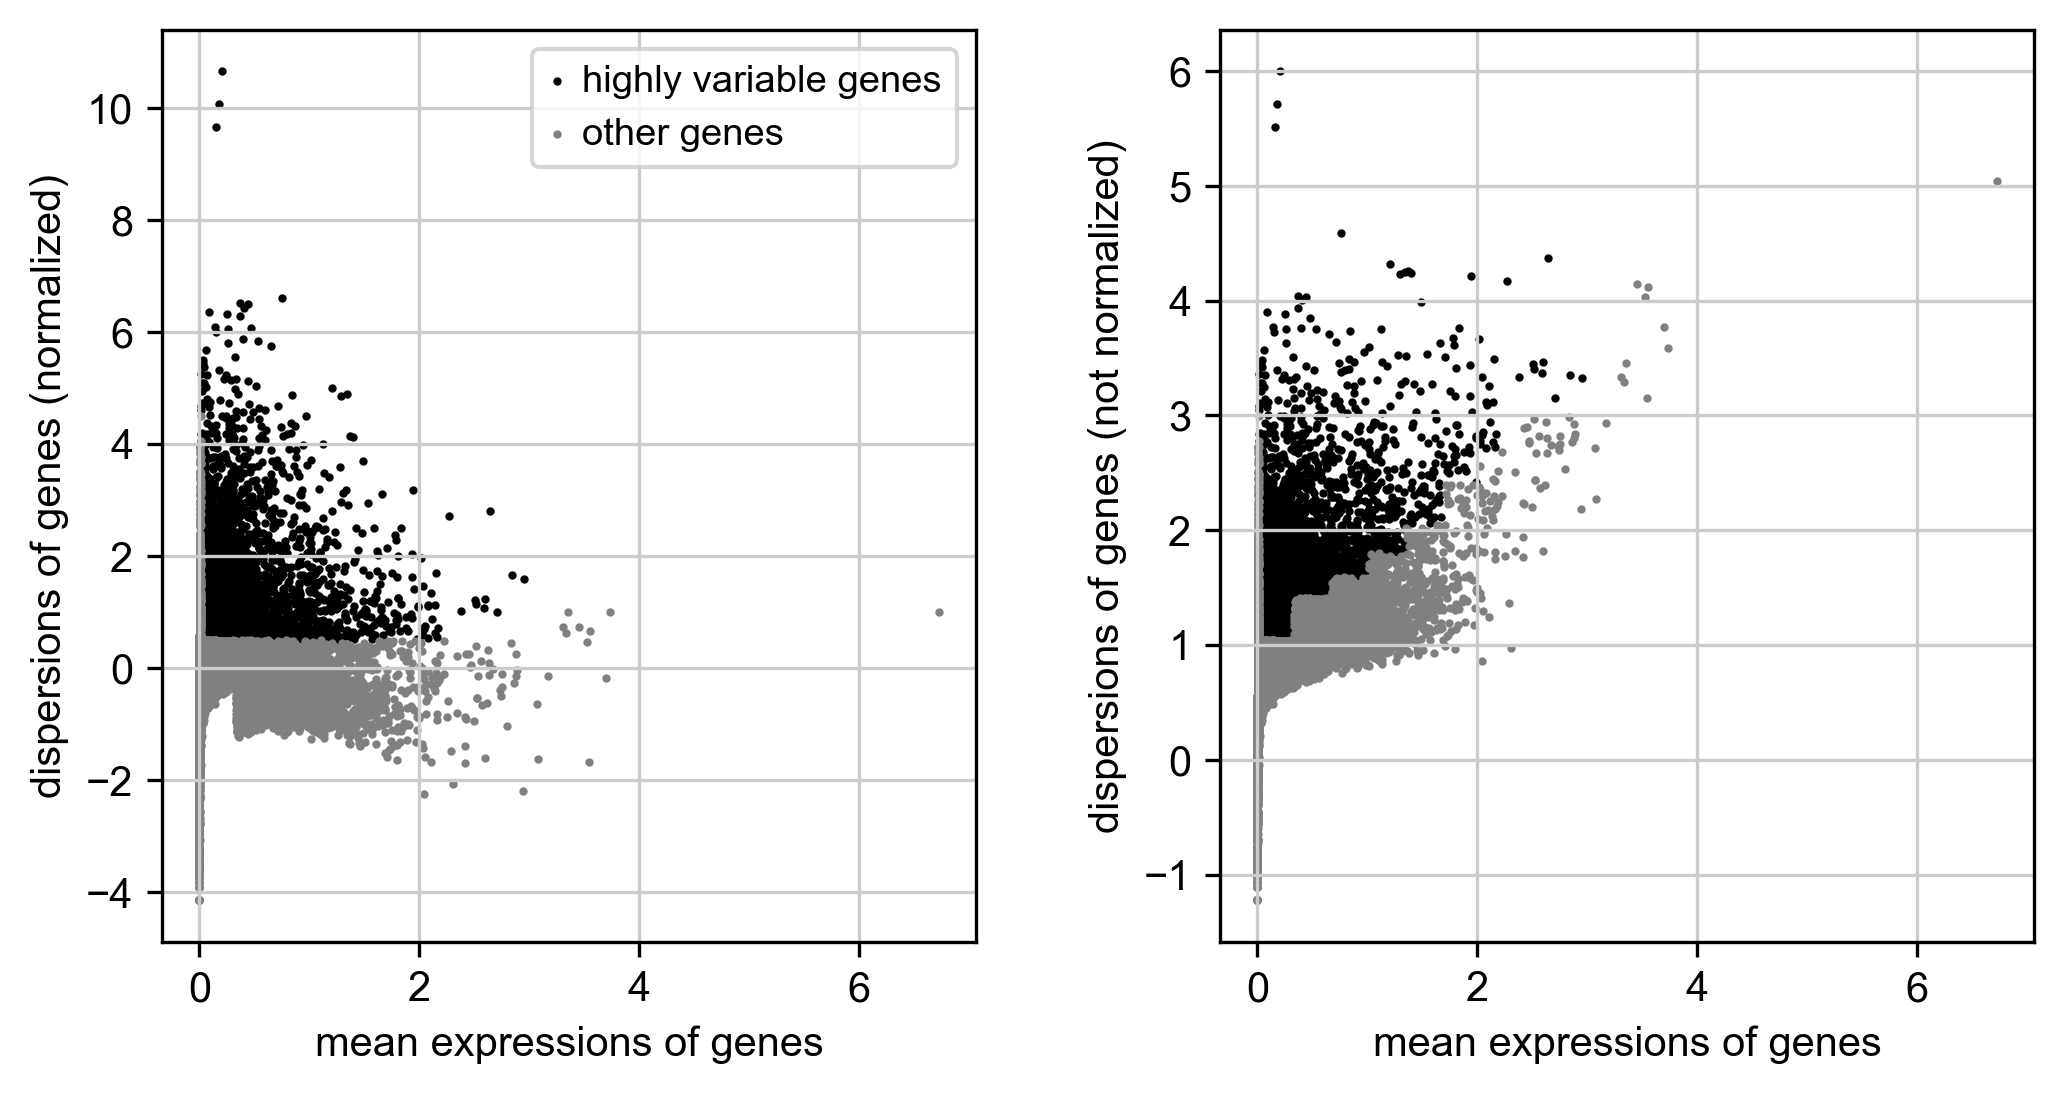

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:17)


/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_24975/3703550910.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


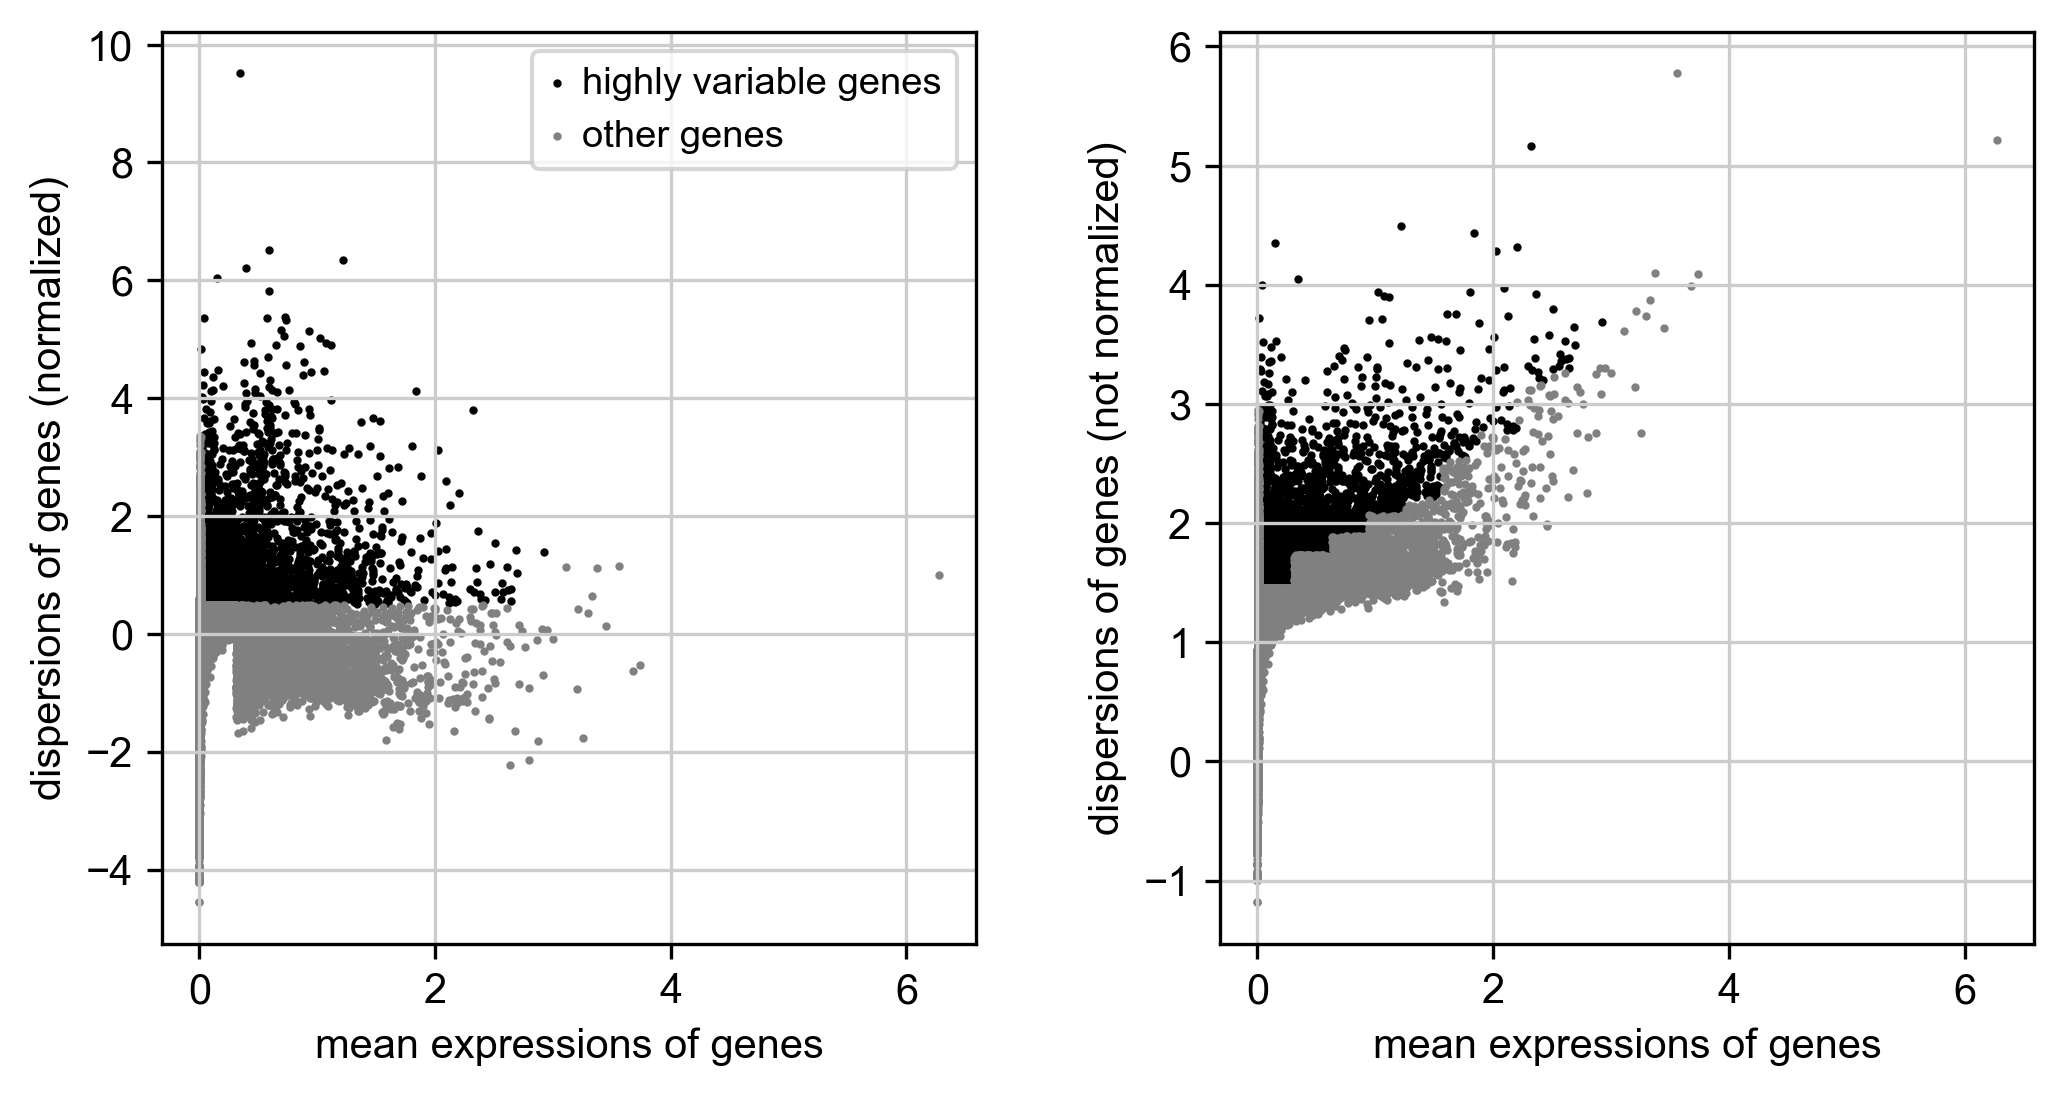

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:45)


('608/2550', '19.25%')

In [21]:
#pair 12
calculator('SF2990')
calculator('SF3073')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_24975/3703550910.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


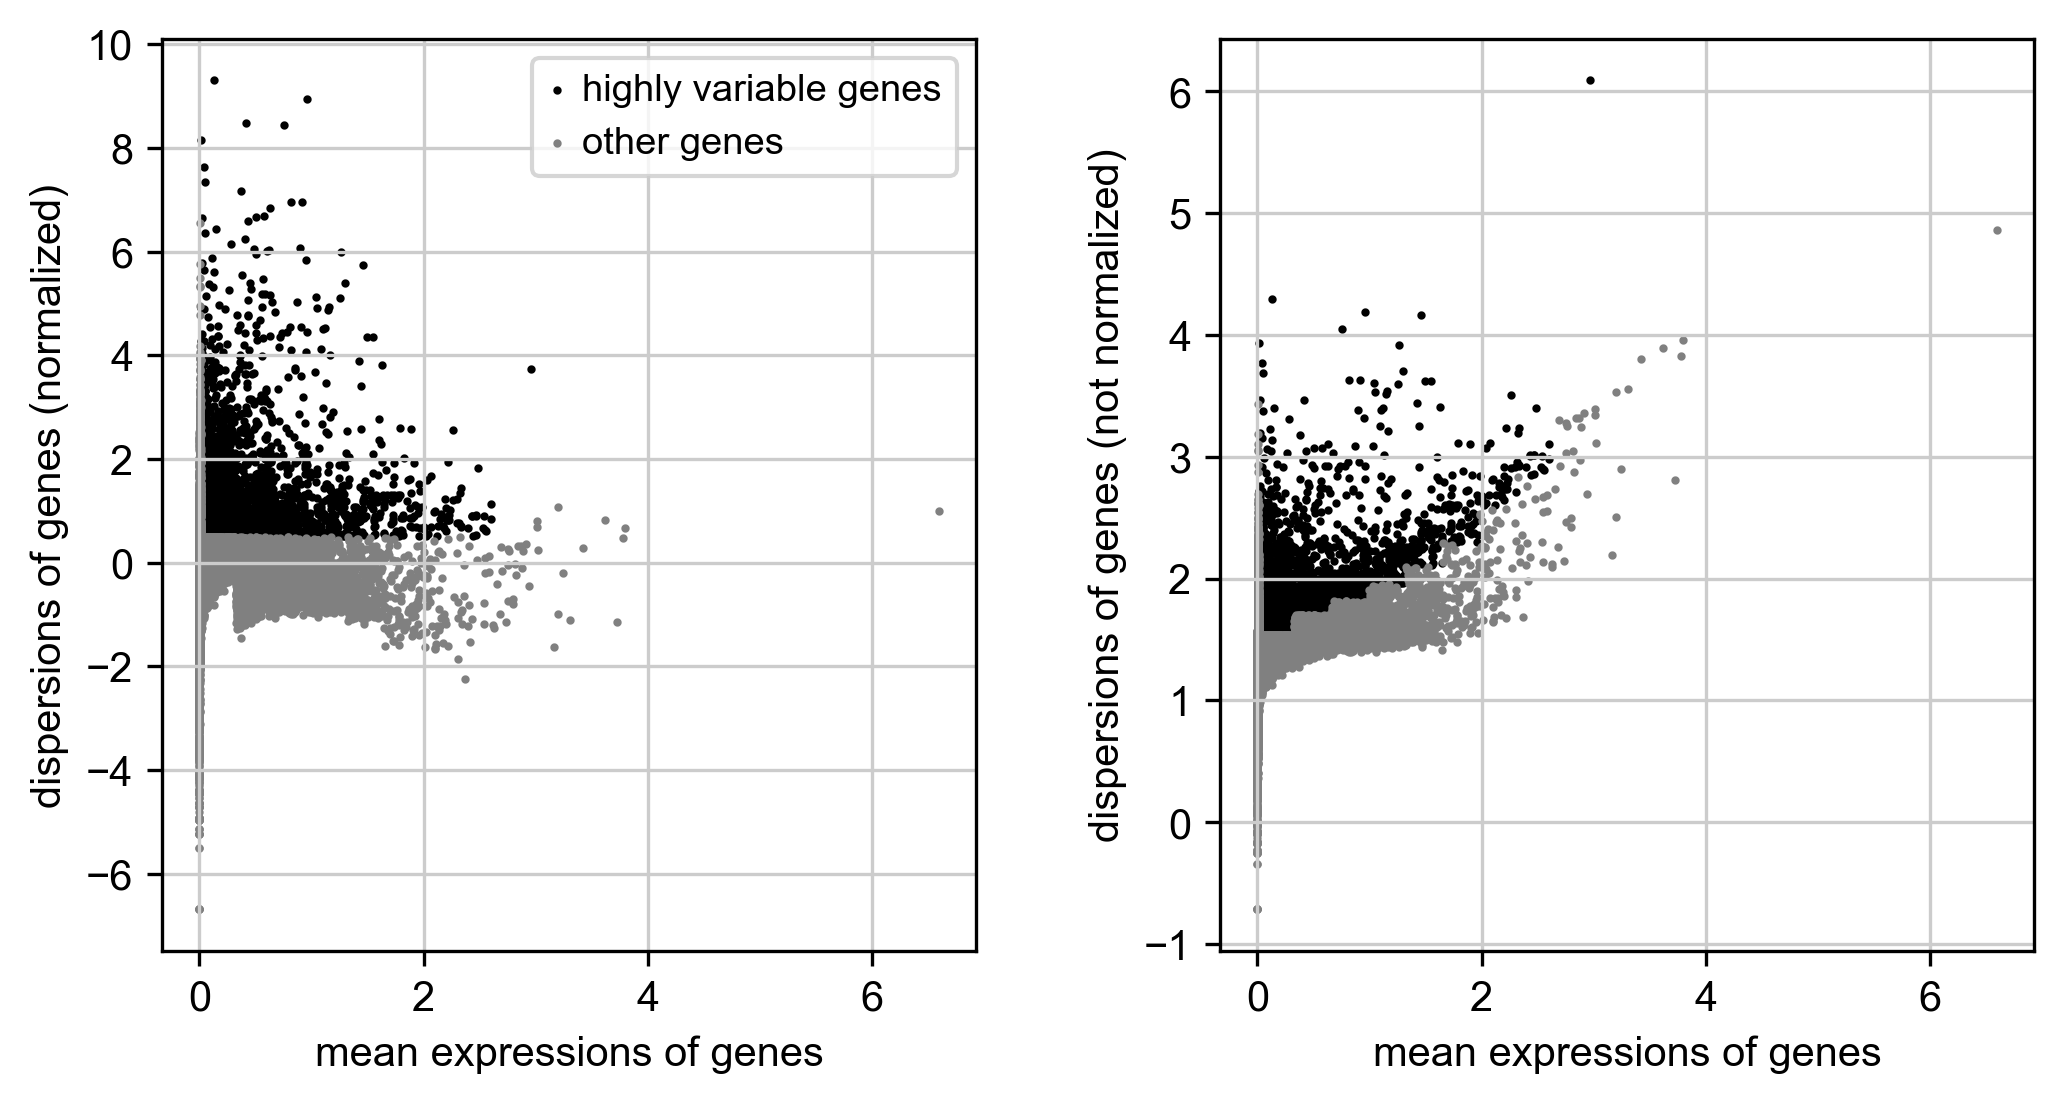

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:01:27)


('589/5194', '10.19%')

In [22]:
#pair 7
calculator('SF11344')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_24975/3703550910.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


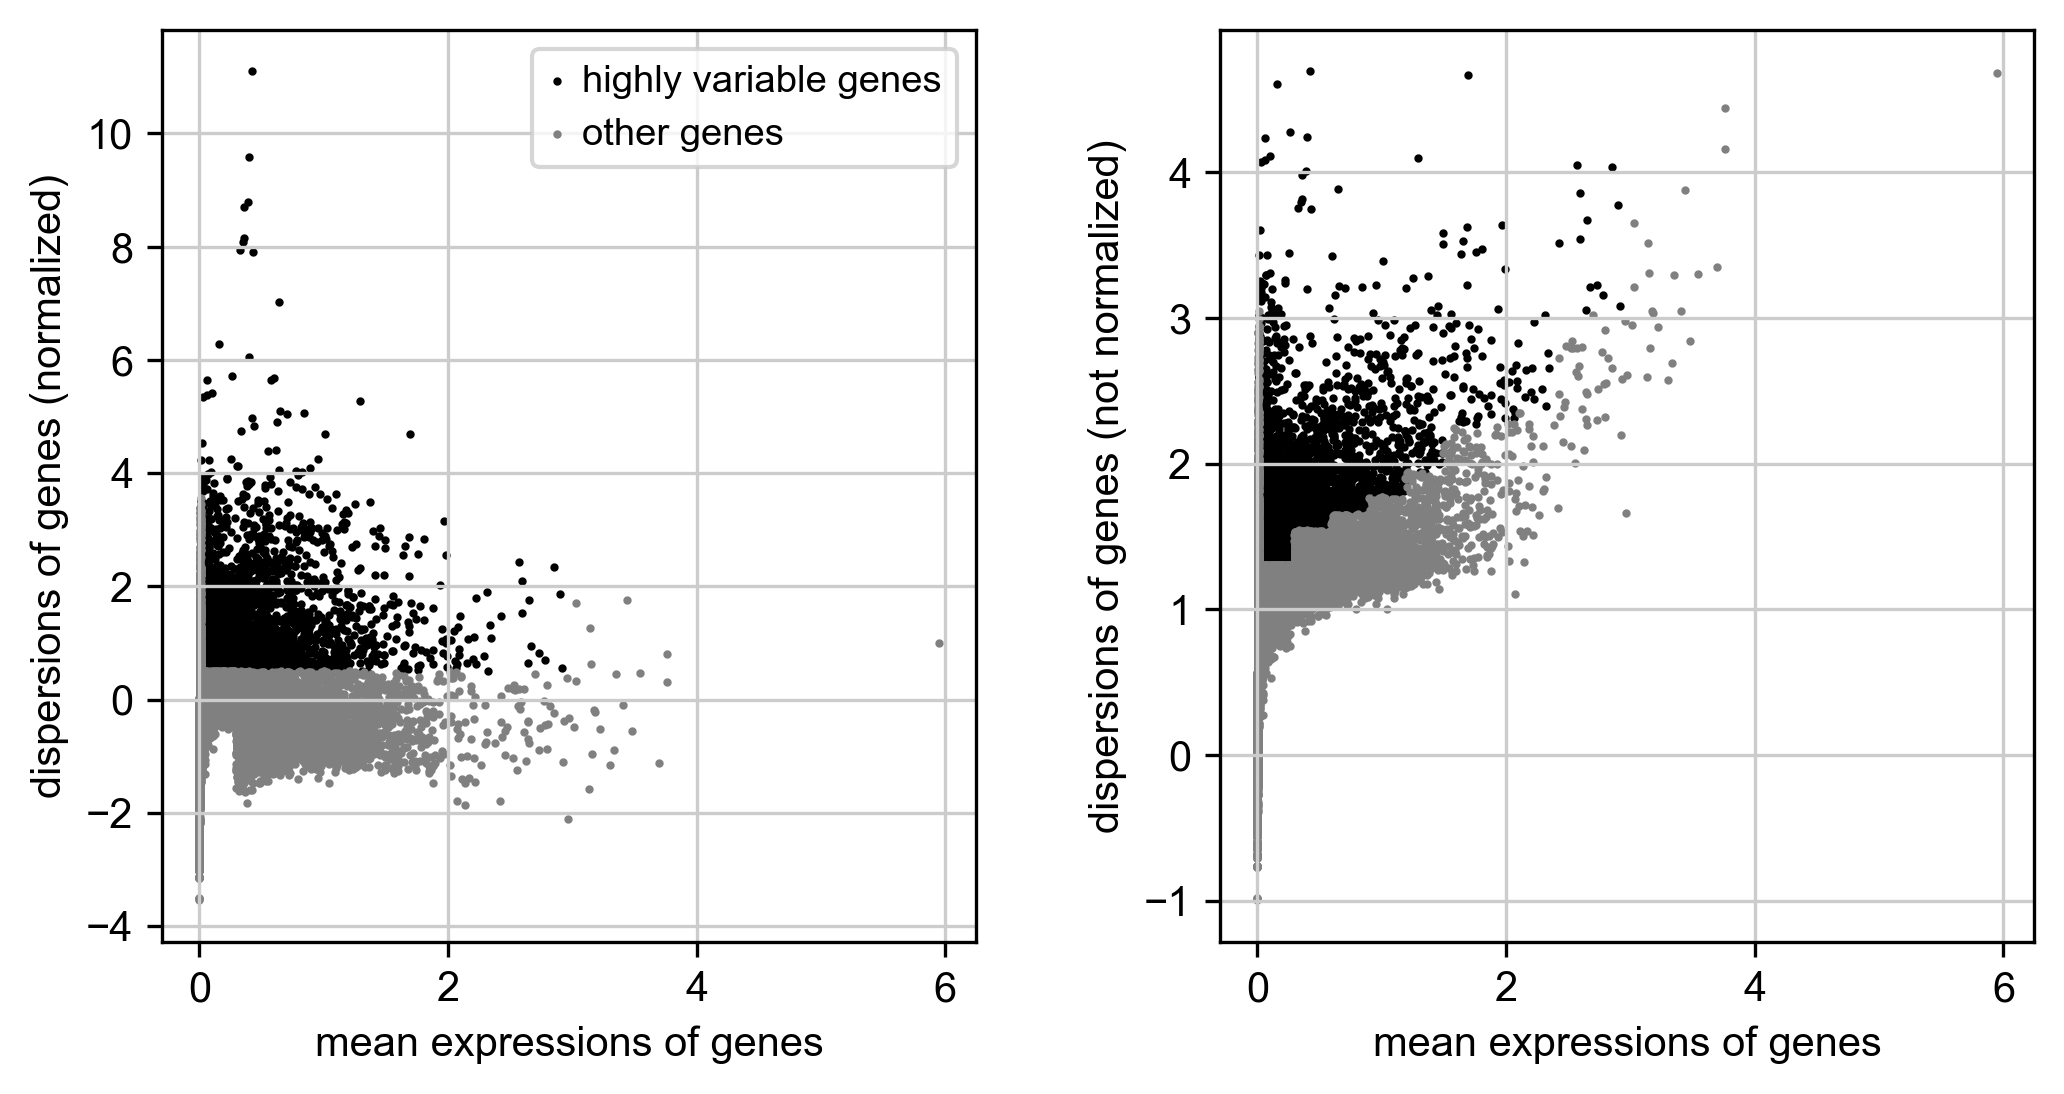

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:34)


('1678/380', '81.54%')

In [24]:
#pair 31
#calculator('SF11916v2')
calculator('SF12382')

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_24975/1896707665.py:45: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


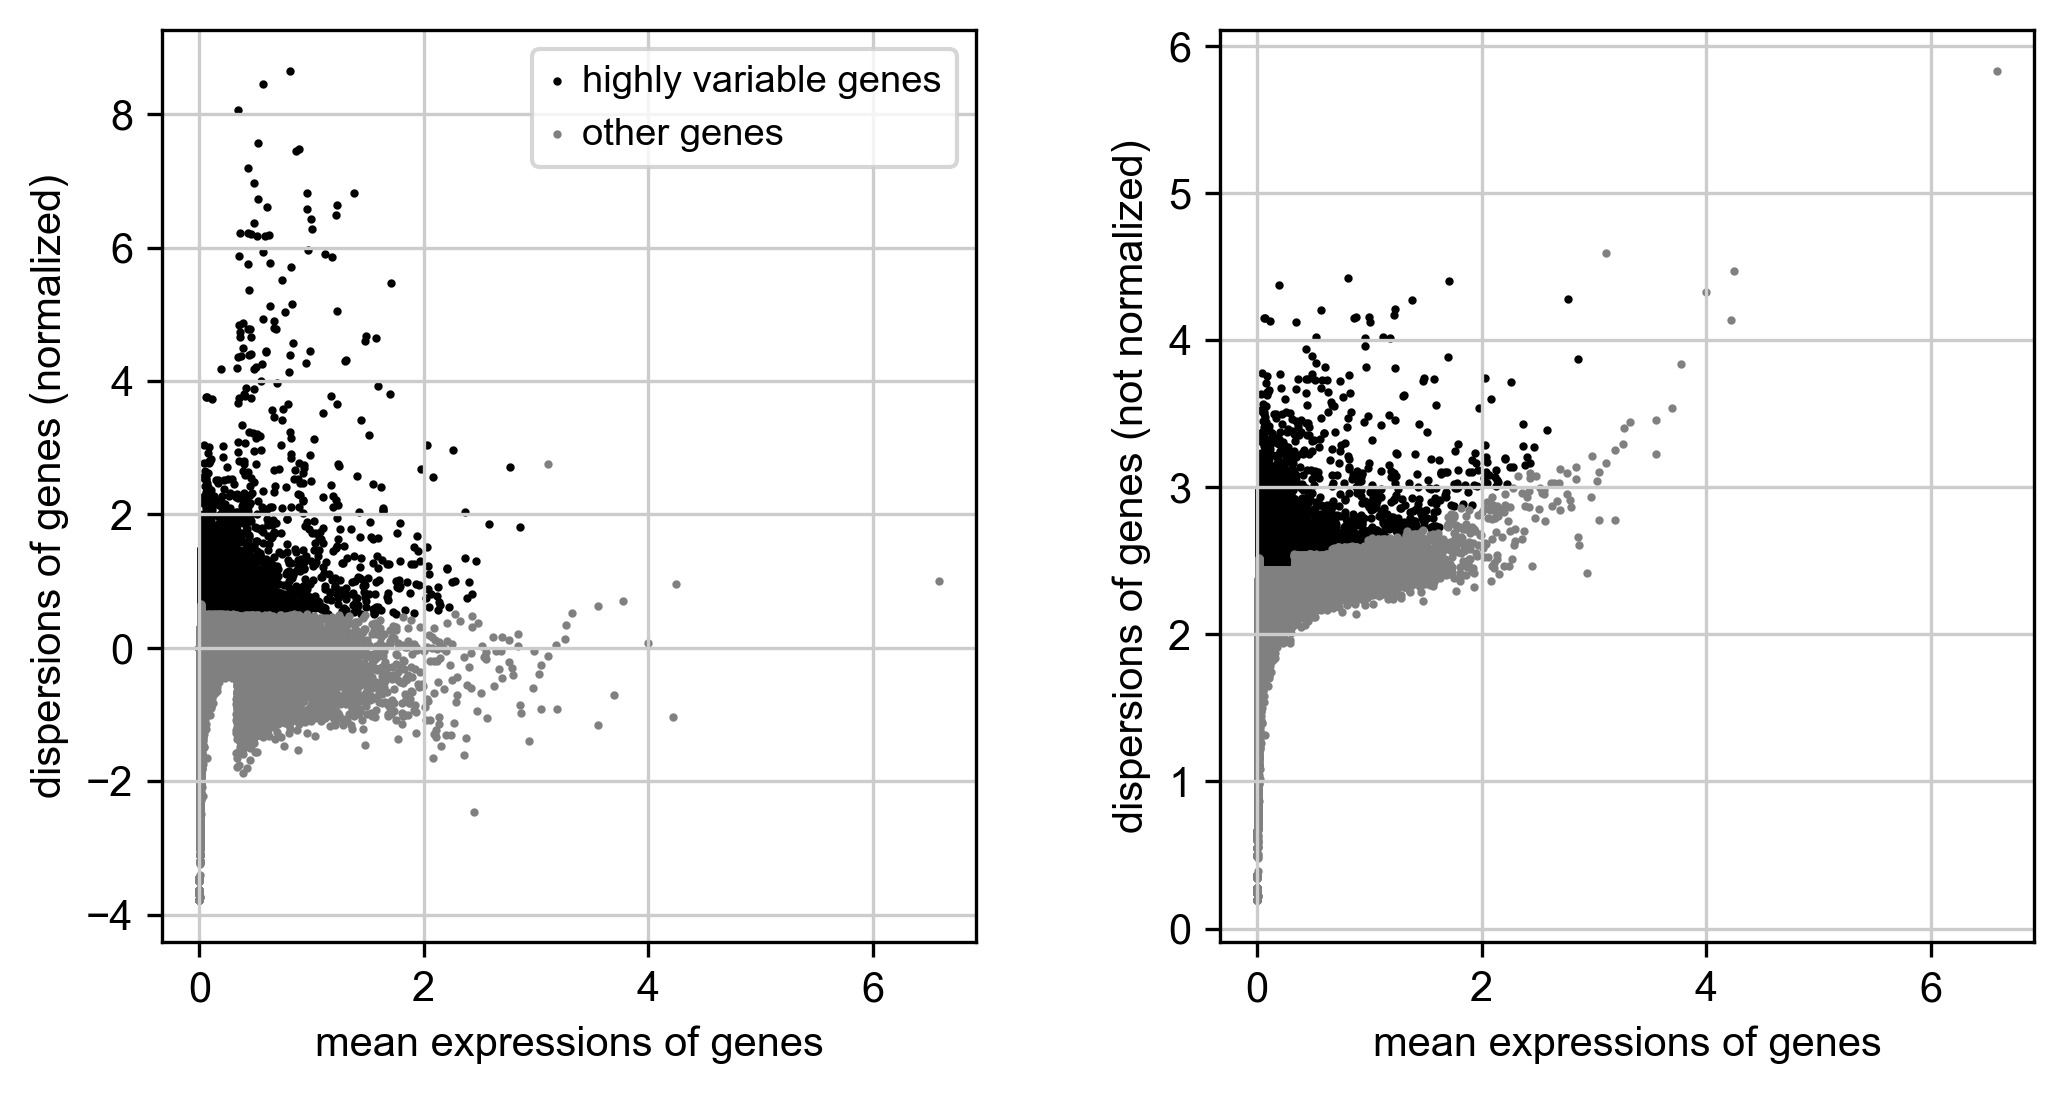

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:21)


In [27]:
calculator('SF11916')


In [ ]:
def prefilter(sample):
    file = "/Users/lidiayung/project/resource/GSE174554_Tumor_normal_metadata.txt"
    metadata= pd.read_csv(file,sep=' ')
    metadata.head()

    new_df = metadata[metadata["Sample#"] == sample].copy()
    tumor = new_df[(new_df['Tumor_Normal_annotation'] == 'Tumor')]
    percent = "{:.2%}".format(len(tumor)/len(new_df))
    
    return percent


In [ ]:
samples = ['SF9871','SF10432','SF10099','SF11587','SF11720','SF11857','SF12704','SF4209','SF4810','SF6186','SF7307','SF9715','SF9962']
results = []
for sample in samples:
    calper = prefilter(sample)
    results.append((sample, calper))

# Create a pandas DataFrame with the results
df_prefilter = pd.DataFrame(results, columns=['Sample', 'percent'])
print(df_prefilter)


In [ ]:
def docidentificator(sample):
    found_doc = []
    resource_folder = "/Users/lidiayung/project/resource/GSE174554_RAW/"
    features_path = glob.glob(f"{resource_folder}/GSM*_{sample}_features.tsv.gz")
    if len(features_path) == 0:
        print(f"No document found for sample {sample}")
        return None
    else:
        found_doc.append(sample)
        return(found_doc)

In [ ]:
samples = ['SF10022', 'SF10099',  'SF10127',  'SF10432',  'SF10857',  'SF11082',  'SF11344',  'SF11587',  'SF11780',  'SF11815',  'SF11873',  'SF11916',  'SF11977',  'SF11979',  'SF1199',  'SF12707',  'SF2501',  'SF2777',  'SF2990',  'SF3076',  'SF3391',  'SF3996',  'SF4209',  'SF4297',  'SF4400',  'SF4810',  'SF4849',  'SF5581',  'SF6809',  'SF6996',  'SF7307',  'SF8963',  'SF9259R',  'SF9259S',  'SF9358',  'SF9372',  'SF9798',  'SF10592',  'SF10108',  'SF10433',  'SF10441',  'SF10484',  'SF10514',  'SF11248',  'SF11720',  'SF11857',  'SF12008',  'SF12090',  'SF12115',  'SF12382',  'SF12427',  'SF12460',  'SF12594',  'SF12616',  'SF12774',  'SF1343',  'SF2628',  'SF2979',  'SF3073',  'SF3243',  'SF3448',  'SF6098',  'SF6186',  'SF6621',  'SF7025',  'SF7062',  'SF7388',  'SF9510',  'SF9494',  'SF9791',  'SF12408',  'SF9715',  'SF11488',  'SF12407',  'SF10565',  'SF12243',  'SF6118',  'SF12165',  'SF9962',  'SF12751',  'SF12704',  'SF12333',  'SF4324',  'SF11981',  'SF12754',  'SF9871',  'SF4449']

In [ ]:
found_doc = []
for sample in samples:
    feature_ids = docidentificator(sample)
    if feature_ids is not None:
        found_doc.append(sample)
print(found_doc)

In [ ]:
len(found_doc)

In [ ]:
#1/7
samples = ['SF10099', 'SF10432', 'SF10857', 'SF11082', 'SF11344', 'SF11587', 'SF11780', 'SF11815', 'SF11873', 'SF11916']
for sample in samples:
    obtainpercentage, post_filtering = calculator(sample)
    results_all.append((sample, obtainpercentage, post_filtering))

# Create a pandas DataFrame with the results
df_results = pd.DataFrame(results_all, columns=['Sample', 'Post-filtering','Percentage'])
print(df_results)

In [ ]:
#2/7
samples = ['SF11977', 'SF1199', 'SF12707', 'SF2501', 'SF2777', 'SF2990', 'SF3076', 'SF3391', 'SF3996', 'SF4209', 'SF4810', 'SF4849']
results_all =[]
for sample in samples:
    obtainpercentage, post_filtering = calculator(sample)
    results_all.append((sample, obtainpercentage, post_filtering))

# Create a pandas DataFrame with the results
df_results = pd.DataFrame(results_all, columns=['Sample', 'Post-filtering','Percentage'])
print(df_results)

In [ ]:
samples=['SF5581', 'SF6809', 'SF7307', 'SF8963', 'SF9358', 'SF9372', 'SF9798', 'SF10592', 'SF10108', 'SF10433', 'SF10441']

for sample in samples:
    try:
        obtainpercentage, post_filtering = calculator(sample)
        results_all.append((sample, obtainpercentage, post_filtering))
    except ValueError as e:
        print(f"Error processing sample {sample}: {str(e)}")

# Create a pandas DataFrame with the results
df_results = pd.DataFrame(results_all, columns=['Sample', 'Post-filtering','Percentage'])
print(df_results)


In [ ]:
df_results.to_pickle('/Users/lidiayung/github/notebooks/GBM/calculation/results_all.pkl')

In [ ]:
unpickled_df = pd.read_pickle(".results.pkl") 
unpickled_df.info()

In [ ]:
pwd

In [ ]:
#4/7
samples= ['SF10484', 'SF10514', 'SF11248', 'SF11720', 'SF11857', 'SF12008', 'SF12115', 'SF12382', 'SF12427', 'SF12460']
for sample in samples:
    obtainpercentage, post_filtering = calculator(sample)
    results_all.append((sample, obtainpercentage, post_filtering))

# Create a pandas DataFrame with the results
df_results = pd.DataFrame(results_all, columns=['Sample', 'Post-filtering','Percentage'])
print(df_results)

In [ ]:
null_results = df_results[df_results['Percentage']=='0.00%']
null_results

In [ ]:
null_results.to_pickle('/Users/lidiayung/github/notebooks/GBM/calculation/null_results.pkl')

In [ ]:
#5/7
samples = ['SF12594', 'SF12616', 'SF12774', 'SF1343', 'SF2628', 'SF2979', 'SF3073', 'SF3243', 'SF3448', 'SF6098', 'SF6186']
for sample in samples:
    obtainpercentage, post_filtering = calculator(sample)
    results_all.append((sample, obtainpercentage, post_filtering))

# Create a pandas DataFrame with the results
df_results = pd.DataFrame(results_all, columns=['Sample', 'Post-filtering','Percentage'])
print(df_results)           

In [ ]:
#6/7
samples = ['SF6621', 'SF7025', 'SF7062', 'SF7388', 'SF9510', 'SF9494', 'SF9791', 'SF12408', 'SF9715', 'SF11488', 'SF12407', 'SF10565']
for sample in samples:
    obtainpercentage, post_filtering = calculator(sample)
    results_all.append((sample, obtainpercentage, post_filtering))

# Create a pandas DataFrame with the results
df_results = pd.DataFrame(results_all, columns=['Sample', 'Post-filtering','Percentage'])
print(df_results)

In [ ]:
#7/7
samples = ['SF12243', 'SF6118', 'SF12165', 'SF9962', 'SF12751', 'SF12704', 'SF12333', 'SF4324', 'SF11981', 'SF12754', 'SF9871', 'SF4449']
for sample in samples:
    obtainpercentage, post_filtering = calculator(sample)
    results_all.append((sample, obtainpercentage, post_filtering))

# Create a pandas DataFrame with the results
df_results = pd.DataFrame(results_all, columns=['Sample', 'Post-filtering','Percentage'])
print(df_results)

In [ ]:
#matchings
matching_list=[]
samples = ['SF10433', 'SF10592', 'SF6118v2', 'SF3996', 'SF12408', 'SF5581', 'SF12115', 'SF6621', 'SF1199', 'SF9358', 'SF12165', 'SF3073', 'SF9791', 'SF6118', 'SF7388', 'SF6809', 'SF12460', 'SF11780', 'SF11082', 'SF9715v2', 'SF11916', 'SF12407', 'SF9510', 'SF4449', 'SF11488', 'SF12754', 'SF1343', 'SF11815', 'SF9494', 'SF7062', 'SF2979', 'SF10514', 'SF10857', 'SF11981', 'SF12333', 'SF12704v2', 'SF6098', 'SF12008', 'SF3448', 'SF10432', 'SF3243', 'SF7025', 'SF10565', 'SF10484', 'SF11977', 'SF3076', 'SF12382', 'SF4324', 'SF2990', 'SF4849', 'SF12427', 'SF12616', 'SF12751', 'SF9798', 'SF10441', 'SF10108', 'SF12243', 'SF11344', 'SF12707', 'SF8963', 'SF12594', 'SF9871', 'SF2777', 'SF11873']
for sample in samples:
    obtainpercentage, post_filtering = calculator(sample)
    matching_list.append((sample, obtainpercentage, post_filtering))

# Create a pandas DataFrame with the results
df_matching = pd.DataFrame(matching_list, columns=['Sample', 'Post-filtering','Percentage'])
print(df_matching)

In [ ]:
samples = ['SF10099_batch2','SF4209_batch2','SF4810_batch2','SF7307_batch2','SF11720_batch2','SF10565_batch2','SF12165_batch2','SF4449_batch2']

found_batch2doc = []
for sample in samples:
    feature_ids = docidentificator(sample)
    if feature_ids is not None:
        found_batch2doc.append(sample)
print(found_batch2doc)


In [ ]:
percentage_0 = batch2[batch2['Percentage'] == 0]